#### Import libraries

In [2]:
import pandas as pd
import datetime as dt

#### Load data

In [3]:
df = pd.read_csv('./data/data.csv')

#### Clean data

In [5]:
# Convert object columns to numeric
df['land_size_sqm'] = pd.to_numeric(df['land_size_sqm'].str.replace(' sqm', ''))
df['house_size_sqm'] = pd.to_numeric(df['house_size_sqm'].str.replace(' sqm', ''))
df['distance_to_school'] = pd.to_numeric(df['distance_to_school'].str.replace('km', ''))
df['distance_to_supermarket'] = pd.to_numeric(df['distance_to_supermarket'].str.replace(' km', ''))
df['house_age'] = pd.to_numeric(df['house_age'].str.replace(' Years', ''))

# Convert Yes/No columns to 1/0
df['large_living_room'] = pd.to_numeric(df['large_living_room'].replace({'No': '0', 'Yes': '1'}))
df['parking_space'] = pd.to_numeric(df['parking_space'].replace({'No': '0', 'Yes': '1'}))
df['front_garden'] = pd.to_numeric(df['front_garden'].replace({'No': '0', 'Yes': '1'}))
df['swimming_pool'] = pd.to_numeric(df['swimming_pool'].replace({'No': '0', 'Yes': '1'}))
df['wall_fence'] = pd.to_numeric(df['wall_fence'].replace({'No': '0', 'Yes': '1'}))
df['water_front'] = pd.to_numeric(df['water_front'].replace({'No': '0', 'Yes': '1'}))
df['room_size'] = pd.to_numeric(df['room_size'].replace({'small': '0', 'medium': '1', 'large': '2', 'extra_large': '3'}))

# Create construction year column
#df['construction_year'] = dt.date.today().year - df['house_age']

# Delete house age column
#del df['house_age']


#### Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

<Axes: xlabel='property_value', ylabel='Count'>

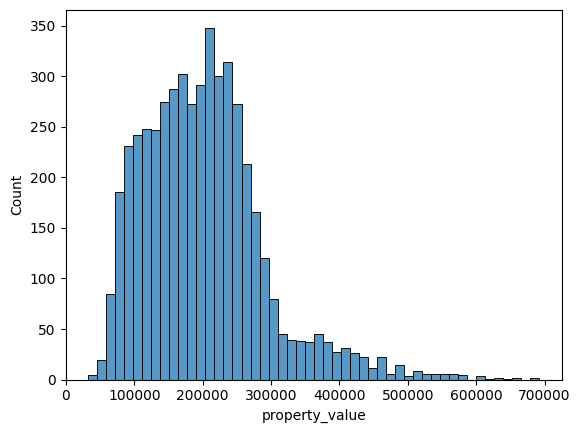

In [7]:
# Plot house prices. We can see there is a long tail effect.
sns.histplot(df.property_value, bins=50)

In [8]:
# Remove long tail by applying log+1 to house price
price_log = np.log1p(df.property_value)

<Axes: xlabel='property_value', ylabel='Count'>

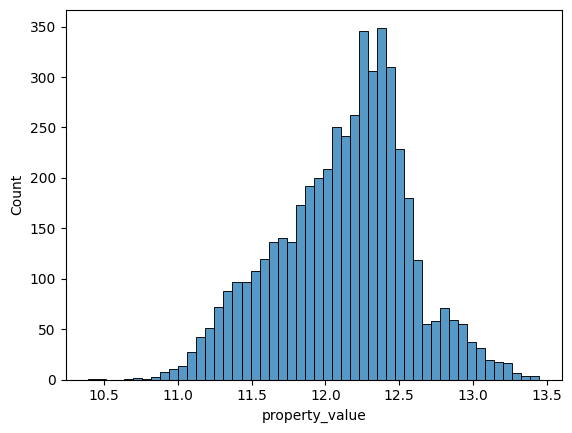

In [9]:
# Plot log+1 house prices
sns.histplot(price_log, bins=50)

In [10]:
# Check for missing values. We don't have any missing values.
df.isnull().sum()

house_id                   0
land_size_sqm              0
house_size_sqm             0
no_of_rooms                0
no_of_bathrooms            0
large_living_room          0
parking_space              0
front_garden               0
swimming_pool              0
distance_to_school         0
wall_fence                 0
house_age                  0
water_front                0
distance_to_supermarket    0
crime_rate_index           0
room_size                  0
property_value             0
dtype: int64

#### Validation framework

In [11]:
# We split our dataset into train (60%), val (20%) and test (20%) datasets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
# Get target variable from the train, val, test datasets
y_train = np.log1p(df_train['property_value'].values)
y_val = np.log1p(df_val['property_value'].values)
y_test = np.log1p(df_test['property_value'].values)

In [12]:
# Delete the target variable from the datasets
del df_train['property_value']
del df_val['property_value']
del df_test['property_value']

In [ ]:
# Save test data to a csv file
df_test.to_csv('./data/test.csv')

#### Feature importance

In [13]:
from sklearn.metrics import mutual_info_score

In [14]:
mi_scores = []

features = df_full_train.columns

for f in features:
    mi_score = mutual_info_score(df_full_train.property_value, df_full_train[f])
    mi_scores.append({'f': f, 's': mi_score})


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [15]:
def sort_list(e):
    return e['s']

mi_scores.sort(reverse=True, key=sort_list)
    

In [16]:
mi_scores

[{'f': 'property_value', 's': np.float64(8.274130280049539)},
 {'f': 'crime_rate_index', 's': np.float64(6.307303354971627)},
 {'f': 'land_size_sqm', 's': np.float64(5.749057605473132)},
 {'f': 'house_size_sqm', 's': np.float64(5.698391887044677)},
 {'f': 'distance_to_school', 's': np.float64(4.126474549105726)},
 {'f': 'distance_to_supermarket', 's': np.float64(4.123743652749198)},
 {'f': 'house_age', 's': np.float64(3.079158172141659)},
 {'f': 'no_of_rooms', 's': np.float64(1.8163983365952991)},
 {'f': 'no_of_bathrooms', 's': np.float64(1.7880081113999897)},
 {'f': 'room_size', 's': np.float64(1.301524649359457)},
 {'f': 'swimming_pool', 's': np.float64(0.6597417925970321)},
 {'f': 'front_garden', 's': np.float64(0.6552260409553051)},
 {'f': 'wall_fence', 's': np.float64(0.654604735625357)},
 {'f': 'large_living_room', 's': np.float64(0.5819151449609423)},
 {'f': 'parking_space', 's': np.float64(0.5423062909196172)},
 {'f': 'water_front', 's': np.float64(0.18839709429779722)}]

#### Train model

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error

In [18]:
# Create dictionaries
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

In [19]:
# Create vectorizer
dv = DictVectorizer(sparse=True)

# Create feature matrices
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

##### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
# Use train dataset to make predictions with lr
y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.10582310483088714)

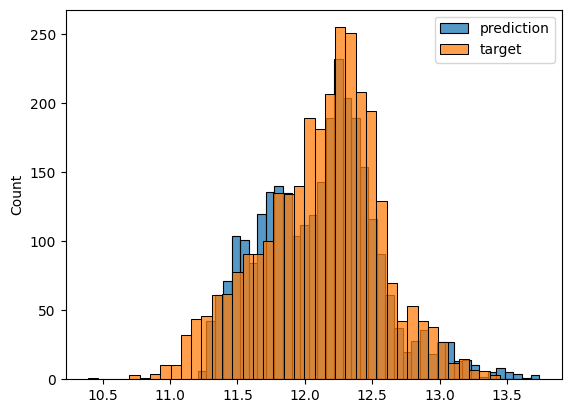

In [23]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [24]:
# Check the model on validation dataset
y_pred = lr.predict(X_val)

In [25]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.10336013785470816)

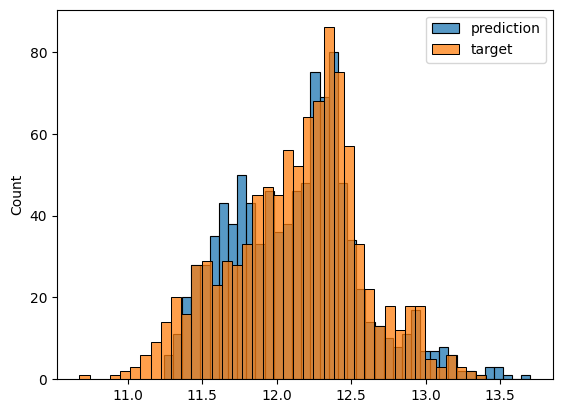

In [26]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

##### Decision tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
# Train decision tree

scores = []

for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
    dt = DecisionTreeRegressor(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)

    # Use val dataset to make predictions with dt
    y_pred = dt.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((d, rmse))


In [29]:
scores

[(1, np.float64(0.2796128149755299)),
 (2, np.float64(0.1752646701309192)),
 (3, np.float64(0.13956559597005203)),
 (4, np.float64(0.11925012404851036)),
 (5, np.float64(0.1111675595731576)),
 (6, np.float64(0.11115271084294681)),
 (7, np.float64(0.10649382222526546)),
 (8, np.float64(0.10714602483787797)),
 (9, np.float64(0.10790888127121995)),
 (10, np.float64(0.10772832283776698)),
 (15, np.float64(0.11642525597832104)),
 (20, np.float64(0.11323200469099313))]

In [30]:
# Now we train with max_depth=7 which gave us the best RMSE value
dt = DecisionTreeRegressor(max_depth=7)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

In [31]:
y_pred = dt.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.07986975763889934)

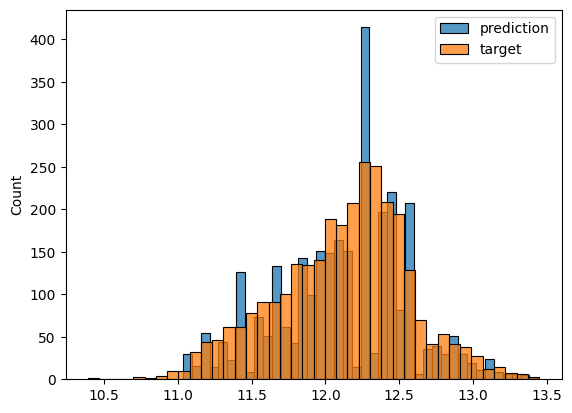

In [32]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [33]:
# Check the model on validation dataset
y_pred = dt.predict(X_val)

In [34]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.10652718645806952)

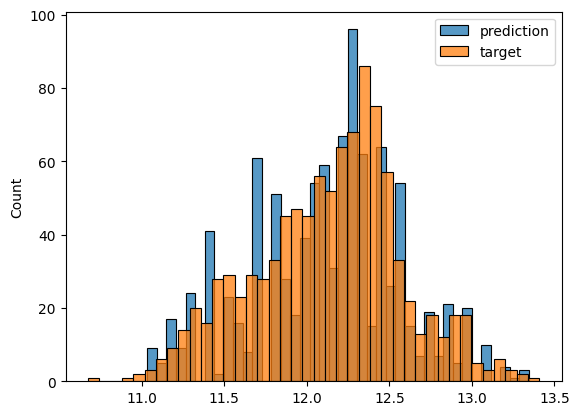

In [35]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

##### Random forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, rmse))

KeyboardInterrupt: 

In [ ]:
scores

[(5, 10, np.float64(0.09878056377140429)),
 (5, 20, np.float64(0.09829776301317848)),
 (5, 30, np.float64(0.0984943384097804)),
 (5, 40, np.float64(0.09814301669191676)),
 (5, 50, np.float64(0.09774787876845721)),
 (5, 60, np.float64(0.09759110969643384)),
 (5, 70, np.float64(0.09741313328128853)),
 (5, 80, np.float64(0.09736136602680388)),
 (5, 90, np.float64(0.09741332632582676)),
 (5, 100, np.float64(0.09740229636181123)),
 (5, 110, np.float64(0.09738554366902549)),
 (5, 120, np.float64(0.09745419360706725)),
 (5, 130, np.float64(0.09759654397077143)),
 (5, 140, np.float64(0.09749680606938274)),
 (5, 150, np.float64(0.09744616283082133)),
 (5, 160, np.float64(0.09737040020954732)),
 (5, 170, np.float64(0.09738012464800147)),
 (5, 180, np.float64(0.09730027172362662)),
 (5, 190, np.float64(0.09725945043839584)),
 (5, 200, np.float64(0.09727287040098052)),
 (10, 10, np.float64(0.08092438428256617)),
 (10, 20, np.float64(0.07887424626943428)),
 (10, 30, np.float64(0.0797278937257939)),

In [21]:
# Train random forest
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=1)

In [22]:
# Use train dataset to make predictions with rf
y_pred = rf.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.029106300110890805)

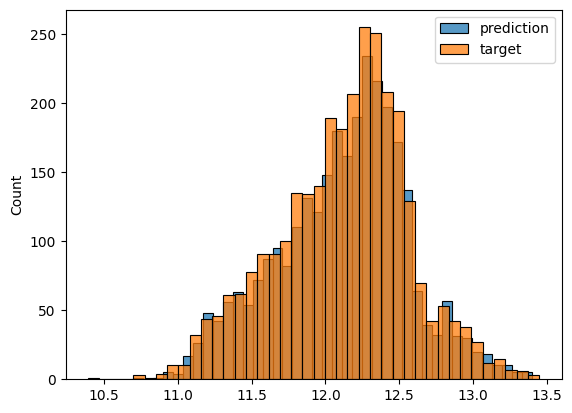

In [23]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [24]:
# Check the model on validation dataset
y_pred = rf.predict(X_val)

In [25]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.07518277083007027)

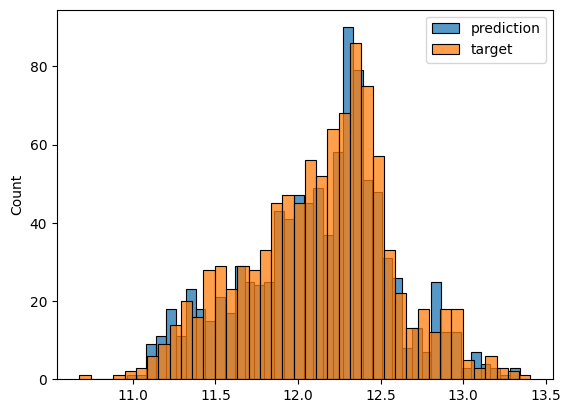

In [26]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

#### Save model

In [44]:
import pickle

In [45]:
# Now we will save the random forest and the model into a file

output_file = 'model.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, rf), f_out)

#### Use model

In [182]:
# Select a house
house = df_test.iloc[420]

# Create dictionary for selected house
house_dict = house.to_dict()

# Create feature matrix for selected house
X_house = dv.transform(house_dict)

In [183]:
house_dict

{'land_size_sqm': 225.0,
 'house_size_sqm': 201.0,
 'no_of_rooms': 3.0,
 'no_of_bathrooms': 2.0,
 'large_living_room': 0.0,
 'parking_space': 0.0,
 'front_garden': 0.0,
 'swimming_pool': 1.0,
 'distance_to_school': 1.4,
 'wall_fence': 1.0,
 'house_age': 18.0,
 'water_front': 0.0,
 'distance_to_supermarket': 4.2,
 'crime_rate_index': 2.82,
 'room_size': 2.0}

In [184]:
# Predict price with Linear Regression model
y_house_pred = np.expm1(lr.predict(X_house))
y_house_pred

array([156456.65689861])

In [185]:
# Predict price with Decision Tree
y_house_pred = np.expm1(dt.predict(X_house))
y_house_pred

array([202276.57257477])

In [186]:
# Predict price with Linear Regression model
y_house_pred = np.expm1(rf.predict(X_house))
y_house_pred

array([180657.68641277])

In [27]:
my_house_dict = {
 'land_size_sqm': 115.0,
 'house_size_sqm': 113.0,
 'no_of_rooms': 1.0,
 'no_of_bathrooms': 1.0,
 'large_living_room': 0.0,
 'parking_space': 0.0,
 'front_garden': 0.0,
 'swimming_pool': 0.0,
 'distance_to_school': 2.6,
 'wall_fence': 0.0,
 'house_age': 21.0,
 'water_front': 0.0,
 'distance_to_supermarket': 4.7,
 'crime_rate_index': 5.64,
 'room_size': 2.0
 }

In [28]:
my_X_house = dv.transform(my_house_dict)

In [29]:
my_y_house_pred = np.expm1(rf.predict(my_X_house))

In [30]:
my_y_house_pred

array([44105.2667739])

In [171]:
df_test

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,large_living_room,parking_space,front_garden,swimming_pool,distance_to_school,wall_fence,house_age,water_front,distance_to_supermarket,crime_rate_index,room_size
0,148,131,2,3,0,0,0,1,4.3,1,15,0,6.5,1.87,0
1,179,174,3,1,0,0,0,1,5.8,1,21,0,6.3,1.79,1
2,274,253,5,2,1,1,1,1,4.5,1,14,0,1.3,0.32,1
3,158,138,2,1,0,1,1,0,6.6,0,17,0,1.1,2.91,1
4,358,351,5,5,1,1,1,1,1.6,0,6,0,4.8,3.61,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,212,207,4,2,1,1,1,0,4.9,1,3,0,4.1,1.63,1
987,251,231,4,4,1,1,1,1,6.8,1,21,0,6.9,3.02,2
988,218,198,4,2,1,1,1,0,4.4,0,19,0,3.3,5.94,1
989,236,228,3,4,1,1,1,0,6.9,1,12,0,5.4,2.01,2
